In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pulp import *
from ortools.linear_solver import pywraplp

from tqdm import tqdm

In [2]:
# Read datasets
df_bio = pd.read_csv('dataset\Biomass_History.csv')
df_dist = pd.read_csv('dataset\Distance_Matrix.csv')
submission = pd.read_csv('dataset\sample_submission.csv')
df_ext = pd.read_excel('dataset\External_Data.xlsx')
df_real = pd.read_csv('dataset\Biomass_Private.csv')

In [3]:
dfcluster = pd.read_csv('./dataset/dfcluster_Unet_29.csv')

# Phase 1

In [4]:
def calc_loss(loss) :
    C = loss['transport'][-1]
    U = loss['underutil'][-1]
    print(f'Transport Loss : {C}')
    print(f'Underutil Loss : {U}')
    print(f'Overall Loss : {C+U}')
    return C, U, (C*0.001)+U

def plot_loss(loss, ax=None):
    sns.lineplot(np.array(loss['transport']) * 0.001, label='Transport Loss (scaled)', ax=ax)
    sns.lineplot(np.array(loss['underutil']), label='Underutilization Loss', ax=ax)
    sns.lineplot(np.array(loss['underutil']) + np.array(loss['transport']) * 0.001, label='Total Loss', ax=ax)

    ax.set_xlabel('Iteration')
    ax.set_ylabel('Costs')
    ax.set_title('Greedy Method')
    ax.legend()

def plot_map (dfcluster, used, group_dict) :
    # Plot used sites and depots
    fig, axes = plt.subplots(ncols=2, figsize=(14,5))
    sns.scatterplot(data=dfcluster[~dfcluster['Index'].isin(used)],x='Longitude',y='Latitude',hue='2018', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[0])
    sns.scatterplot(data=dfcluster[~dfcluster['Index'].isin(used)],x='Longitude',y='Latitude',hue='2019', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[1])
    sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(used)], x='Longitude', y='Latitude', color='orange', s=20, linewidth=0, ax=axes[0])
    sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(used)], x='Longitude', y='Latitude', color='orange', s=20, linewidth=0, ax=axes[1])
    sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(list(group_dict.keys()))], x='Longitude', y='Latitude', color='red', s=20, linewidth=0, ax=axes[0])
    sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(list(group_dict.keys()))], x='Longitude', y='Latitude', color='red', s=20, linewidth=0, ax=axes[1])
    axes[0].set_title('Config 2018')
    axes[1].set_title('Config 2019')
    plt.tight_layout()
    plt.show()

In [5]:
def assign_greedy(maxval_index, dfcluster, avail, used, cap):
    group_assign = []
    transport_loss = 0
    group_assign.append(maxval_index)
    distances = df_dist[str(maxval_index)].copy()/((avail['2018']+avail['2019'])/2)
    
    while True :
        distances.loc[used+group_assign] = np.nan
        closest = np.nanargmin(distances.tolist())
        dist = df_dist[str(closest)][maxval_index]

        current_biomass = (dfcluster[dfcluster['Index'].isin(group_assign)]['2018'].sum(), dfcluster[dfcluster['Index'].isin(group_assign)]['2019'].sum())
        add_biomass = (dfcluster[dfcluster['Index']==closest]['2018'].values[0], dfcluster[dfcluster['Index']==closest]['2019'].values[0])
        if (current_biomass[0] + add_biomass[0] > cap) or (current_biomass[1] + add_biomass[1] > cap) :
            break

        group_assign.append(closest)
        transport_loss += dist*add_biomass[0] + dist*add_biomass[1]

    underutil_loss = (2*cap - current_biomass[0] - current_biomass[1])

    return group_assign, transport_loss, underutil_loss

def assign_year(year, maxval_index, used, avail, cap=20000):
    group_assign = [1 if x == maxval_index else 0 for x in range(2418)]
    transport_loss, underutil_loss = 0, 0
    while True :
        distances = df_dist[str(maxval_index)].copy()
        distances = np.where(np.logical_or(used[year],group_assign), np.nan, distances)
        closest = np.nanargmin(distances.tolist())
        dist = df_dist[str(closest)][maxval_index]

        current_biomass = (dfcluster[year]*pd.Series(group_assign, dtype=bool)).sum()
        add_biomass = dfcluster[dfcluster['Index']==closest][year].values[0]

        if current_biomass + add_biomass > cap :
            # ratio = (cap - current_biomass)/add_biomass
            # group_assign[closest] = ratio
            # transport_loss += dist*add_biomass*ratio
            break

        group_assign[closest] = 1

        transport_loss += dist*add_biomass

    underutil_loss = cap - (dfcluster[year]*group_assign).sum()

    return group_assign, transport_loss, underutil_loss

def stage1(dfcluster, cap) :
    losses = {'transport':[],'underutil':[]}
    C_current, U_current = 0,0
    group_dict = {}
    used = []
    annual_collected = (0,0)
    annual_threshold = (dfcluster['2018'].sum()*0.8, dfcluster['2019'].sum()*0.8)

    # while (annual_collected[0]<annual_threshold[0]) or (annual_collected[1]<annual_threshold[1]) :
    for i in range(15) :
        avail = dfcluster[~dfcluster['Index'].isin(used)]
        maxval_index = ((avail['2018']+avail['2019'])/2).idxmax()

        group_assign, C, U = assign_greedy(maxval_index=maxval_index, dfcluster=dfcluster, avail=avail, used=used, cap=cap)

        used += group_assign
        group_dict[maxval_index] =  group_assign

        C_current += C
        U_current += U

        losses['transport'].append(C_current)
        losses['underutil'].append(U_current)

        annual_collected = (dfcluster[dfcluster['Index'].isin(used)]['2018'].sum(), dfcluster[dfcluster['Index'].isin(used)]['2019'].sum())
        print(f'Total biomass : {annual_collected}')
    
    return used, group_dict, losses

def stage1_v2(dfcluster, cap):
    cap = 20000

    losses = {'transport':[],'underutil':[]}
    C_current, U_current = 0,0
    group_dict = {}
    used = {'2018':[0 for x in range(2418)], '2019':[0 for x in range(2418)]}
    annual_collected = {'2018':0, '2019':0}
    annual_threshold = {'2018':dfcluster['2018'].sum()*0.8, '2019':dfcluster['2019'].sum()*0.8}

    # while (annual_collected['2018']<annual_threshold['2018']) or (annual_collected['2019']<annual_threshold['2019']) :
    for i in range(15) :
        avail = (dfcluster['2018']+dfcluster['2019'])*(~pd.Series(used['2018'], dtype=bool))*(~pd.Series(used['2019'], dtype=bool))
        maxval_index = avail.idxmax()
        group_dict[maxval_index] = {}
        collected = {}

        for year in ['2018','2019'] :
            assign, t, u = assign_year(year=year, maxval_index=maxval_index, used=used, avail=avail, cap=cap)
            group_dict[maxval_index][year] = assign
            used[year] = [a | b for a, b in zip(used[year], [1 if value > 0 else 0 for value in assign])]
            C_current += t
            U_current += u
            collected[year] = (cap-u)

        losses['transport'].append(C_current)
        losses['underutil'].append(U_current)

        annual_collected['2018'] += collected['2018']
        annual_collected['2019'] += collected['2019']
        print(f'Total biomass : {annual_collected}')
        
    return used, group_dict, losses

In [6]:
used_greed, group_dict_greed, loss_greed = stage1(dfcluster, cap=20000)
calc_loss(loss_greed)

Total biomass : (18269, 19994)
Total biomass : (25316, 39824)
Total biomass : (45126, 59731)
Total biomass : (63629, 79469)
Total biomass : (81575, 99246)
Total biomass : (92373, 119038)
Total biomass : (111788, 138999)
Total biomass : (125332, 158945)
Total biomass : (142414, 178811)
Total biomass : (152811, 198770)
Total biomass : (171494, 218678)
Total biomass : (191377, 238595)
Total biomass : (209816, 258510)
Total biomass : (227142, 278309)
Total biomass : (247069, 297940)
Transport Loss : 31807105.078300003
Underutil Loss : 54991
Overall Loss : 31862096.078300003


(31807105.078300003, 54991, 86798.1050783)

In [7]:
used_greed_v2, group_dict_greed_v2, loss_greed_v2 = stage1_v2(dfcluster, cap=20000)
calc_loss(loss_greed_v2)

Total biomass : {'2018': 19648, '2019': 19817}
Total biomass : {'2018': 39431, '2019': 39729}
Total biomass : {'2018': 59281, '2019': 59610}
Total biomass : {'2018': 79121, '2019': 79607}
Total biomass : {'2018': 98834, '2019': 99244}
Total biomass : {'2018': 118774, '2019': 118869}
Total biomass : {'2018': 138710, '2019': 138803}
Total biomass : {'2018': 158628, '2019': 158794}
Total biomass : {'2018': 178428, '2019': 178624}
Total biomass : {'2018': 198428, '2019': 198459}
Total biomass : {'2018': 218414, '2019': 218260}
Total biomass : {'2018': 238399, '2019': 238229}
Total biomass : {'2018': 258357, '2019': 258191}
Total biomass : {'2018': 278345, '2019': 278181}
Total biomass : {'2018': 298315, '2019': 298127}
Transport Loss : 37807596.8933
Underutil Loss : 3558
Overall Loss : 37811154.8933


(37807596.8933, 3558, 41365.5968933)

no u : 41886.829  
with u : 45261.613    
no u closest : 38291.827  
with u closest : 36621.808

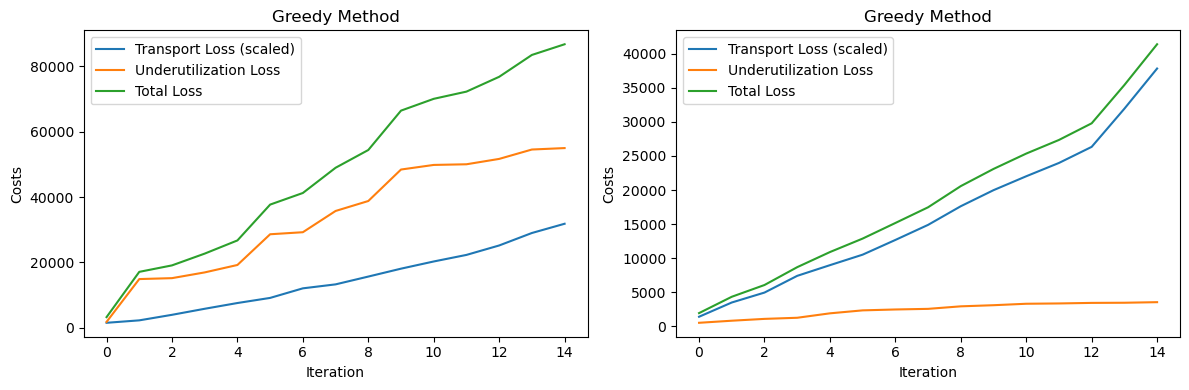

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plot_loss(loss_greed, ax=axes[0])
plot_loss(loss_greed_v2, ax=axes[1])
plt.tight_layout()
plt.show()

In [10]:
biomass_collected = {'2018':0, '2019':0}
for key, val in group_dict_greed_v2.items():
    for year, assign in val.items():
        biomass_collected[year] += (dfcluster[year]*assign).sum()

print(biomass_collected)
print(loss_greed_v2['transport'][-1]*0.001, loss_greed_v2['underutil'][-1])

{'2018': 298315, '2019': 298127}
37807.5968933 3558


In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
df_plot = pd.concat([dfcluster, pd.Series(used_greed_v2['2018'],name='used_2018'), pd.Series(used_greed_v2['2019'],name='used_2019')],axis=1)

sns.scatterplot(data=df_plot[df_plot['used_2018']==0],x='Longitude',y='Latitude', hue='2018', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=df_plot[df_plot['used_2019']==0],x='Longitude',y='Latitude', hue='2019', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[1])
sns.scatterplot(data=df_plot[df_plot['used_2018']==1], x='Longitude', y='Latitude', color='orange', s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=df_plot[df_plot['used_2019']==1], x='Longitude', y='Latitude', color='orange', s=20, linewidth=0, ax=axes[1])
sns.scatterplot(data=df_plot[df_plot['Index'].isin(list(group_dict_greed_v2.keys()))], x='Longitude', y='Latitude', color='red', s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=df_plot[df_plot['Index'].isin(list(group_dict_greed_v2.keys()))], x='Longitude', y='Latitude', color='red', s=20, linewidth=0, ax=axes[1])
axes[0].set_title('Config 2018')
axes[1].set_title('Config 2019')
plt.tight_layout()
plt.show()

In [ ]:
used_2018 = []
group_dict_2018 = {}
costs_2018 = []
for iter_index in tqdm(range(15), desc='Optimize'):
    avail = dfcluster[~dfcluster['Index'].isin(used_2018)]
    max_iter = 5
    maxval_index = avail['2018'].nlargest(max_iter).index.tolist()
    Sites = avail['Index'].tolist()
    Depots = maxval_index
    Biomass = avail.copy()['2018']
    cap = 20000

    solver = pywraplp.Solver.CreateSolver('SCIP')
    if not solver:
        raise Exception("Solver initialization failed")

    use_depot = {}
    assign_depot = {}

    for j in Depots:
        use_depot[j] = solver.BoolVar(f"Use Depot {j}")

    for i in Sites:
        for j in Depots:
            assign_depot[(i, j)] = solver.BoolVar(f"Assign Depot {i},{j}")

    trans_cost = solver.Sum(
        df_dist[str(j)][int(i)] * Biomass[i] * assign_depot[i, j]
        for i in Sites for j in Depots
    )

    under_cost = solver.Sum(
        cap * use_depot[j] - solver.Sum(
            Biomass[i] * assign_depot[i, j] for i in Sites
        ) for j in Depots
    )

    # Combine transportation cost and fixed cost for the total cost
    total_cost = trans_cost*0.001 + under_cost
    solver.Minimize(total_cost)

    solver.Add(solver.Sum(use_depot[j] for j in Depots) == 1)

    for i in Sites:
        for j in Depots:
            solver.Add(assign_depot[i, j] <= use_depot[j])

    for j in Depots:
        solver.Add(solver.Sum(Biomass[i] * assign_depot[i, j] for i in Sites) - cap * use_depot[j] <= 0)
        # solver.Add(solver.Sum(Biomass[i] * assign_depot[i, j] for i in Sites) - 0.9 * cap * use_depot[j] >= 0)

    for i in Sites:
        solver.Add(solver.Sum(assign_depot[i, j] for j in Depots) <= 1)

    status = solver.Solve()

    losses = (total_cost.solution_value(), trans_cost.solution_value(), under_cost.solution_value())
    costs_2018.append(losses)

    variable_values = {
        var.name(): var.solution_value() for var in [use_depot[j] for j in Depots] +
        [assign_depot[i, j] for i in Sites for j in Depots]
    }

    group_assign_dict = {}
    centers = []
    for var_name, var_value in variable_values.items():
        if var_value > 0 :
            line = var_name
            if line.startswith('Assign Depot'):
                key = int(line.split(',')[1])
                value = int(line.split(',')[0].split(' ')[2])
                if key in group_assign_dict:
                    group_assign_dict[key].append(value)
                else:
                    group_assign_dict[key] = [value]
            else :
                centers.append(int(line.split(' ')[2]))

    for value_list in group_assign_dict.values():
        used_2018.extend(value_list)

    group_dict_2018.update(group_assign_dict)
    print(centers, losses)

In [ ]:
median_index = 1218
median_dist = df_dist[str(median_index)]

depot_list = list(group_dict_2018.keys())
depot_list_sorted = median_dist[median_dist.index.isin(depot_list)].sort_values(ascending=False).index.tolist()

In [ ]:
used_2019 = [] 
group_dict_2019 = {}
costs_2019 = []
for iter_index in tqdm(range(3), desc='opt_2019') :
    print(f'Iter no: {iter_index+1}')
    Depots = depot_list_sorted[5*iter_index:5*(iter_index+1)]
    Sites = dfcluster[~dfcluster['Index'].isin(used_2019 + depot_list_sorted[5*(iter_index+1):])]['Index'].tolist()
    Biomass = dfcluster.copy()['2019']
    cap = 20000

    solver = pywraplp.Solver.CreateSolver('SCIP')
    if not solver:
        raise Exception("Solver initialization failed")

    assign_depot = {}

    for i in Sites:
        for j in Depots:
            assign_depot[(i, j)] = solver.BoolVar(f"Assign Depot {i},{j}")

    trans_cost = solver.Sum(
        df_dist[str(j)][int(i)] * Biomass[i] * assign_depot[i, j]
        for i in Sites for j in Depots
    )

    under_cost = solver.Sum(
        cap - solver.Sum(
            Biomass[i] * assign_depot[i, j] for i in Sites
        ) for j in Depots
    )

    # Combine transportation cost and fixed cost for the total cost
    total_cost = trans_cost*0.001 + under_cost
    solver.Minimize(total_cost)

    for j in Depots:
        solver.Add(solver.Sum(Biomass[i] * assign_depot[i, j] for i in Sites) - cap <= 0)
        solver.Add(assign_depot[j, j] == 1)

    for i in Sites:
        solver.Add(solver.Sum(assign_depot[i, j] for j in Depots) <= 1)

    status = solver.Solve()
    print(total_cost.solution_value())

    losses = (total_cost.solution_value(), trans_cost.solution_value(), under_cost.solution_value())
    costs_2019.append(losses)

    variable_values = {
        var.name(): var.solution_value() for var in 
        [assign_depot[i, j] for i in Sites for j in Depots]
    }

    group_assign_dict = {}
    centers = []
    for var_name, var_value in variable_values.items():
        if var_value > 0 :
            line = var_name
            if line.startswith('Assign Depot'):
                key = int(line.split(',')[1])
                value = int(line.split(',')[0].split(' ')[2])
                if key in group_assign_dict:
                    group_assign_dict[key].append(value)
                else:
                    group_assign_dict[key] = [value]
            else :
                centers.append(int(line.split(' ')[2]))

    for value_list in group_assign_dict.values():
        used_2019.extend(value_list)

    group_dict_2019.update(group_assign_dict)

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
sns.scatterplot(data=dfcluster[~dfcluster['Index'].isin(used_2018)],x='Longitude',y='Latitude',hue='2018', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster[~dfcluster['Index'].isin(used_2019)],x='Longitude',y='Latitude',hue='2019', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[1])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(used_2018)], x='Longitude', y='Latitude', color='orange', s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(used_2019)], x='Longitude', y='Latitude', color='orange', s=20, linewidth=0, ax=axes[1])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(list(group_dict_2018.keys()))], x='Longitude', y='Latitude', color='red', s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(list(group_dict_2019.keys()))], x='Longitude', y='Latitude', color='red', s=20, linewidth=0, ax=axes[1])
axes[0].set_title('Config 2018')
axes[1].set_title('Config 2019')
plt.tight_layout()
plt.show()

In [ ]:
total_cost = 0
transport_cost = 0
underutil_cost = 0
for costs_ in [costs_2018, costs_2019] :
    for cost in costs_:
        total_cost += cost[0]
        transport_cost += cost[1]
        underutil_cost += cost[2]

print(f'Total cost : {total_cost}')
print(f'Total transport : {transport_cost*0.001}')
print(f'Total underutil : {underutil_cost}')

1 to 15, in to out : 33783  
1 to 15, out to in : 33896

In [ ]:
biomass_dict = {'2018':{}, '2019':{}}
for keys in group_dict_greed_v2.keys():
    for year in ['2018','2019']:
        biomass_collected = np.sum(dfcluster[year]*group_dict_greed_v2[keys][year])
        biomass_dict[year][keys] = (biomass_collected)

biomass_dict_2018 = biomass_dict['2018']
biomass_dict_2019 = biomass_dict['2019']

In [11]:
biomass_dict_2018 = {}
for keys in group_dict_greed.keys() :
    biomass_collected = 0
    for site in group_dict_greed[keys]:
        biomass_collected += dfcluster.loc[dfcluster['Index']==site]['2018'].values[0]
    biomass_dict_2018[keys] = biomass_collected
    
biomass_dict_2019 = {}
for keys in group_dict_greed.keys() :
    biomass_collected = 0
    for site in group_dict_greed[keys]:
        biomass_collected += dfcluster.loc[dfcluster['Index']==site]['2019'].values[0]
    biomass_dict_2019[keys] = biomass_collected

In [12]:
dfdepot = pd.DataFrame(biomass_dict_2018.items(), columns=['depot_index','2018'])
dfdepot['2019'] = biomass_dict_2019.values()

In [15]:
Depot = dfdepot['depot_index'].tolist()
Refinery = dfcluster['Index'].tolist()
Years = ['2018','2019']
Pellets = dfdepot.set_index('depot_index').to_dict()
Cap = 100000

solver = pywraplp.Solver.CreateSolver('SCIP')
if not solver:
    raise Exception("Solver initialization failed")

# Create use_refinery variables
use_refinery = {}
for k in Refinery:
    use_refinery[k] = solver.BoolVar(f"Use Refinery {k}")

# Create assign_refinery variables
assign_refinery = {}
for j in Depot:
    for k in Refinery:
        for y in Years:
            assign_refinery[(j, k, y)] = solver.BoolVar(f"Assign Refinery ({j}, {k}, {y})")

# Define transport cost
trans_cost = sum(sum(df_dist[str(k)][int(j)] * (Pellets[y][j]) * assign_refinery[(j, k, y)] for j in Depot for k in Refinery) for y in Years)

# Define underutilization cost
under_cost = sum(sum(Cap*use_refinery[k]-sum((Pellets[y][j])*assign_refinery[j,k,y] for j in Depot) for k in Refinery) for y in Years)

objective = trans_cost * 0.001 + under_cost
solver.Minimize(objective)

for y in Years :
    for k in Refinery :
        assignment_sum = sum(assign_refinery[j,k,y] for y in Years)
        solver.Add(assignment_sum == len(Years) * assign_refinery[(j, k, Years[0])])
        solver.Add(sum(Pellets[y][j]*assign_refinery[j,k,y] for j in Depot) - Cap*use_refinery[k] <= 0)

for y in Years :
    for j in Depot :
        solver.Add(sum(assign_refinery[j,k,y] for k in Refinery) == 1)

for y in Years :
    for j in Depot :
        for k in Refinery :
            solver.Add(assign_refinery[j,k,y] <= use_refinery[k])

solver.Add(sum(use_refinery.values()) >= 3)
solver.Add(sum(use_refinery.values()) <= 5)

status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print("Solution status: Optimal")
else:
    print("Solution status: Not optimal")

print("Total costs:", solver.Objective().Value())

assign ={}
use = []
for k in Refinery:
    if (use_refinery[k].solution_value()>0):
        use.append(k)
        
    for j in Depot:
        if (assign_refinery[(j, k, '2018')].solution_value()>0):
            if k in assign:
                assign[k].append(j)
            else :
                assign[k] = [j]

# for i in use:
#     if i not in used_2018:
#         used_2018.append(i)
#     if i not in used_2019:
#         used_2019.append(i)

Solution status: Optimal
Total costs: 104934.10549270014


In [16]:
trans_cost.solution_value(), under_cost.solution_value()

(49943105.4927, 54991.0)

In [17]:
transport_cost, underutil_cost, _ = calc_loss(loss_greed)

Transport Loss : 31807105.078300003
Underutil Loss : 54991
Overall Loss : 31862096.078300003


Enet : 31.96  
Unet : 29.47  
ConvLSTM : 25.37

In [18]:
# Calculate the total costs
total_transport = transport_cost + trans_cost.solution_value()
total_under = underutil_cost + under_cost.solution_value()
total_forecast = 29.47*2*2418
total_cost = 0.001*total_transport + total_under + total_forecast

score = 100 - (80*total_cost)/500000
score

46.52013910864

In [19]:
total_cost, 0.001*total_transport, total_under, total_forecast

(334249.130571, 81750.21057100002, 109982.0, 142516.91999999998)

| No  | Phase 1     | Phase 2 Stage 1 | Phase 2 Stage 2 | C     | F     | U     | OC    |
|-----|-------------|-----------------|-----------------|-------|-------|-------|-------|
| 1   | Enet        | Greed - 14D     | MILP            | 87469.45 | 154558.56 | 91714 | 333742.01 |
| 2   | Unet        | Greed - 15D  | MILP            | 81750.21 | 142516.91 | 109982 | 334249.13 |
| 3   | Unet        | Greed V2 - 15D  | MILP            | 91625.08 | 142516.91 | 7116 | 241258.00 |
| 4   | ConvLSTM    | Greed V2 - 14D  | MILP            | 83266.86 | 122689.32 | 45506 | 251462.18 |
| 5   | ConvLSTM    | Greed V2 - 15D  | MILP            | 92003.13 | 122689.32 | 5894 | 220586.45 |
| 6   | ConvLSTM    | MILP - 15D      | MILP            | 89895.16 | 122689.32 | 0 | 212584.48 |


In [ ]:
# TODO : Local Search

In [ ]:
# Plot the whole configuration network
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
sns.scatterplot(data=dfcluster[~dfcluster['Index'].isin(used_2018)],x='Longitude',y='Latitude',hue='2018', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster[~dfcluster['Index'].isin(used_2019)],x='Longitude',y='Latitude',hue='2019', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[1])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(used_2018)], x='Longitude', y='Latitude', color='orange', s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(used_2019)], x='Longitude', y='Latitude', color='orange', s=20, linewidth=0, ax=axes[1])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(list(group_dict_2018.keys()))], x='Longitude', y='Latitude', color='red', s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(list(group_dict_2019.keys()))], x='Longitude', y='Latitude', color='red', s=20, linewidth=0, ax=axes[1])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(use)], x='Longitude', y='Latitude', color='black', s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(use)], x='Longitude', y='Latitude', color='black', s=20, linewidth=0, ax=axes[1])
axes[0].set_title('Config 2018')
axes[1].set_title('Config 2019')
plt.tight_layout()
plt.show()